# Project ABS
The goal of this notebook will be to explore data compiled from the Australian Bureau of Statistics (ABS) compiled as part of their [AUSSTATS](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1410.02013-18?OpenDocument) documentation, looking at trends across a wide variety of "key measures" by geographical region within Australia.

Preliminarily I am interested in exploring ties between income and age (for potential use in later analysis on tax effects on different generations), but there are also some interesting factoids regarding solar panel installations which have piqued my curiousity.

Note all files were originally ".xls" format, and have had incredibly minor alterations as follows:
* Removing "branding" and "page header" rows (rows 1-5 in source document)
* Removing "Copyright" and empty "footer" columns at the end of the dataset
* Consolidating all the details outlined in the column headers into 1 header per column (removing merged formatting and cross filling for empty cells)
* Saving each document as .csv

All files are based on the ASGS (Australian Statistical Geography Standard) location methodology. There is potential of further exploration based on documents located [here](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202011?OpenDocument).

# Imports Section

In [1]:
# Declare Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import seaborn as sns
import os
from textwrap import wrap
import eli5
import operator

solar = 'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.'

In [2]:
# Set a variable for current notebook's path for various loading/saving mechanisms
nb_path = os.getcwd()

In [10]:
# Create list of all files in CSV directory
files = []

for (dirpath, dirnames, filenames) in os.walk('{}\CSV'.format(nb_path)):
    files.extend(filenames)
    break

for f in files:
    if f[-4:] != '.csv':
        files.remove(f)

In [11]:
#load all the files into a single df
df = pd.read_csv('{}\CSV\{}'.format(nb_path, files[0]), na_values='-', thousands=',')

for file in range(1,len(files)):
    df_temp = pd.read_csv('{}\CSV\{}'.format(nb_path, files[file]), na_values='-', thousands=',')
    df = pd.merge(df, df_temp, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

In [12]:
# Load in latitude and longitude data
df_temp = pd.read_csv('{}\latlng.csv'.format(nb_path), na_values='-', thousands=',')
df_temp.rename(columns = {df_temp.columns[0] : 'LABEL'}, inplace=True)
df = pd.merge(df, df_temp, how='inner', left_on='LABEL', right_on='LABEL')

df.head()

,CODE,LABEL,YEAR,NUMBER OF BUSINESSES Number of non-employing businesses no.,NUMBER OF BUSINESSES 1-4 employees no.,NUMBER OF BUSINESSES 5-19 employees no.,NUMBER OF BUSINESSES 20 or more employees no.,NUMBER OF BUSINESSES Total number of businesses no.,BUSINESS ENTRIES Number of non-employing business entries no.,BUSINESS ENTRIES 1-4 employees no.,...,RELIGIOUS AFFILIATION Judaism %,RELIGIOUS AFFILIATION Other Religions %,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %",RELIGIOUS AFFILIATION Inadequately described or not stated %,AUSTRALIAN CITIZENSHIP Australian citizen %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,AUSTRALIAN CITIZENSHIP Australian Citizenship - Not stated %,SPEAKS A LANGUAGE OTHER THAN ENGLISH AT HOME Proportion of total population %,lat,long
0,10102,Queanbeyan,2016,2730.0,1331.0,450.0,85.0,4596.0,388.0,173.0,...,0.1,1.1,29.2,10.0,87.0,5.4,7.7,12.0,-35.352466,149.233725
1,101021009,Queanbeyan,2016,402.0,193.0,89.0,27.0,712.0,75.0,32.0,...,0.1,2.1,28.5,10.5,80.6,11.2,8.2,21.2,-35.352466,149.233725
2,10202,Wyong,2016,4573.0,3006.0,895.0,178.0,8657.0,781.0,540.0,...,0.1,0.4,26.6,8.1,89.7,4.2,6.2,4.8,-33.285641,151.425306
3,102021057,Wyong,2016,322.0,193.0,85.0,23.0,631.0,40.0,34.0,...,0.1,0.7,28.6,9.4,86.1,6.3,7.6,8.2,-33.285641,151.425306
4,10301,Bathurst,2016,2369.0,1123.0,412.0,79.0,3991.0,284.0,144.0,...,NaN,0.4,22.6,11.7,86.9,3.4,9.7,4.0,-33.474707,149.641320


In [3]:
def remove_aggregation(df):
    df.drop(df[df['CODE'].astype(str).map(len) <= 8].index, inplace=True)
    return df

In [3]:
df.reset_index(inplace=True)

df = remove_aggregation(df)

df.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)

df['Solar Per Household'] = df[solar]/df['HOUSEHOLDS BY TYPE Total households no.']

NameError: name 'df' is not defined

In [4]:
def clean_data(df, y_column, fill_mean_subset = None):
    '''
    A function to clean a dataframe and return X & y values for further processing. 
    Rows are removed where NaNs are present in response vector records.
    NaN values for all other features are filled with the mean of the feature.
    
    INPUT
    df - pandas dataframe 
    y_column - String. Name of column to be used as the response vector
    fill_mean_subset - String, column name. Allows the input of a column to "subset" when first completing
                        imputing missing numerical values with a series mean. E.g. if there is a categorical 
                        field of "year", allows imputing of null values with the mean of each year, rather 
                        than the mean of the overall series.  
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''    
    # Remove duplicate columns
    drop_cols = []
    check_cols = df.columns.tolist()
    check_cols.sort()
    w_end = len(check_cols)
    i = 0
    
    # Cycle through each column name
    while i < w_end:
        # assign a Check variable the the column name as a string
        # that name string should only include characters up to 1 character after the final space
        # e.g. "* %" or "* n"
        check_str = check_cols[i]
        check_str = check_str[:(check_str.rfind(" ")+2)]
        
        for col in check_cols[(i+1):]:
            # look forward in the list of column names for any other items matching CheckString & "*"
            # add any matches to a list to drop, drop from the "check" list as well so make further searches more efficient.
            # I'm almost certain there is a more efficient way to do this list/dict-wise
            if col.startswith(check_str):
                drop_cols.append(col)
                check_cols.remove(col)
                w_end -= 1
        i += 1  
    
    df.drop(drop_cols, axis = 1, inplace=True)
    
    # Drop rows with missing response values
    df = df.dropna(subset=[y_column], axis=0)
    y = df[y_column]
    df = df.dropna(how = 'all', axis = 1)
    #Drop response column
    df = df.drop(y_column, axis=1)
    
    # Fill numeric columns with the mean    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    # First, fill with the mean of the subset based on given category
    if fill_mean_subset != None:
        index_reset = False
        index_names = list(df.index.names)
        
        # Filtering sucks with multi-indexing so temporarily reset the indexes for this action
        if fill_mean_subset in index_names:
            index_reset = True
            df.reset_index(inplace=True)

        #Check if subset variable is an index item
        for subset_item in df[fill_mean_subset].unique().tolist():
            for col in num_vars:
                subset_mean = df[df[fill_mean_subset] == subset_item][col].mean() 
                df.loc[(df[fill_mean_subset] == subset_item) & (df[col].isnull()), col] = subset_mean
        
        if index_reset:
            df.set_index(index_names, inplace=True)

    # For any remaining nulls, fill with the mean of the overall series
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # OHE the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # Fill OHE NaNs with 0
    # Get list of columns after OHE that were not in the "numeric" list from earlier, using set function for speed.
    cat_vars = list(set(df.columns.tolist()) - set(num_vars.tolist()))
    for var in cat_vars:
        df[var].fillna(0, inplace=True)
    
    X = df
    return X, y

In [5]:
def sort_series_abs(S):
    'Takes a pandas Series object and returns the series sorted by absolute value'
    temp_df = pd.DataFrame(S)
    temp_df['abs'] = temp_df.iloc[:,0].abs()
    temp_df.sort_values('abs', ascending = False, inplace = True)
    return temp_df.iloc[:,0]

In [6]:
def plot_bar_comparisons(df, num_cols):
    '''
    Takes a dataframe object and plots each row as a bar chart using the index as the 
    chart title and the other columns as X-axis labels, within a 5x(n/5) subplot frame
    df: dataframe object with values from which you want a chart of each row
    num_cols: the number of charts per output row
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    fig, axs = plt.subplots(nrows = int(rows/num_cols + rows%num_cols), ncols = num_cols, sharey = True,
                           figsize=(15,int(rows*0.66)))
    i=1
    for row in axs:
        for ax in row:
            if i <= rows:
                sns.barplot(data = df.iloc[i-1:i,:], ax = ax)
                ax.title.set_text(df.index[i-1])
            else:
                ax.axis('off')
            i += 1
    plt.tight_layout()    
    plt.show()

In [7]:
# For fun exploration, let's just run a histogram over everything!
def histo_plots(df, num_cols):
    '''
    Takes a dataframe object and plots each column as a histogram chart using the feature title as the 
    chart title and the other columns as X-axis labels, within an n*(len/n) subplot frame
    df: dataframe object with values from which you want a chart of each row
    num_cols: the number of charts per output row
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    plot_rows = (int(columns/num_cols) + ((columns%num_cols)!=0))
    fig, axs = plt.subplots(nrows = plot_rows, 
                            ncols = num_cols, sharey = False, figsize=(15,columns))
    nlines = 1

    for i in range(axs.shape[0]*axs.shape[1]):
        #print(i)
        if i < columns:
            try:
                df.iloc[:,i].dropna().plot.hist(ax = axs[int(i/num_cols),int(i%num_cols)])
                axs[int(i/num_cols),i%num_cols].set_title("\n".join(wrap(df.columns[i], int(100/num_cols))))
                nlines = max(nlines,axs[int(i/num_cols),int(i%num_cols)].get_title().count('\n'))
            
            except:
                axs[int(i/num_cols),i%num_cols].set_title("\n".join(wrap(df.columns[i], 100/num_cols)))
                axs[int(i/num_cols),i%num_cols].axis('off')
        else:
            axs[int(i/num_cols),int(i%num_cols)].axis('off')
    
    fig.subplots_adjust(hspace=0.5*nlines)
    plt.tight_layout()    
    plt.show()

In [8]:
def feature_plot(importances, X_train, n_features):
    
    # Display the n most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    values = importances[indices][:n_features]
    
    columns = [ '\n'.join(wrap(c, 20)) for c in columns ]
    
    # Create the plot
    fig = plt.figure(figsize = (9,n_features))
    plt.title("Normalized Weights for {} Most Predictive Features".format(n_features), fontsize = 16)
    plt.bar(np.arange(n_features), values, width = 0.6, align="center", color = '#00A000', 
          label = "Feature Weight")
    plt.bar(np.arange(n_features) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', 
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(n_features), columns, rotation = 'vertical')
    #plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    #plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()  

In [9]:
def feature_plot_h(importances, X_train, n_features):
    # Display the n most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    values = importances[indices][:n_features]
    
    columns = [ '\n'.join(wrap(c, 20)) for c in columns ]
    
    # Create the plot
    fig = plt.figure(figsize = (9,n_features))
    plt.title("Normalized Weights for {} Most Predictive Features".format(n_features), fontsize = 16)
    plt.barh(np.arange(n_features), values, height = 0.6, align="center", color = '#00A000', 
          label = "Feature Weight")
    plt.barh(np.arange(n_features) - 0.3, np.cumsum(values), height = 0.2, align = "center", color = '#00A0A0', 
          label = "Cumulative Feature Weight")
    plt.yticks(np.arange(n_features), columns)
    plt.xlabel("Weight", fontsize = 12)
    
    plt.legend(loc = 'upper right')
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()  

In [24]:
def feature_impact_plot(model, X_train, n_features, y_label):
    '''
    Takes a trained model and training dataset and synthesises the impacts of the top n features
    to show their relationship to the response vector (i.e. how a change in the feature changes
    the prediction). Returns n plots showing the variance for min, max, median, 1Q and 3Q.
    
    INPUTS
    model = Trained model in sklearn with  variable ".feature_importances_". Trained supervised learning model.
    X_train = Pandas Dataframe object. Feature set the training was completed using.
    n_features = Int. Top n features you would like to plot.
    y_label = String. Description of response variable for axis labelling.
    '''
    # Display the n most important features
    indices = np.argsort(model.feature_importances_)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    
    sim_var = [[]]
    
    for col in columns:
        base_pred = model.predict(X_train)
        #add percentiles of base predictions to a df for use in reporting
        base_percentiles = [np.percentile(base_pred, pc) for pc in range(0,101,25)]

        # Create new predictions based on tweaking the parameter
        # copy X, resetting values to align to the base information through different iterations
        df_copy = X_train.copy()

        for val in np.arange(-X_train[col].std(), X_train[col].std(), X_train[col].std()/50):
            df_copy[col] = X_train[col] + val
            # Add new predictions based on changed database
            predictions = model.predict(df_copy)
            
            # Add percentiles of these predictions to a df for use in reporting
            percentiles = [np.percentile(predictions, pc) for pc in range(0,101,25)]
            
            # Add variances between percentiles of these predictions and the base prediction to a df for use in reporting
            percentiles = list(map(operator.sub, percentiles, base_percentiles))
            percentiles = list(map(operator.truediv, percentiles, base_percentiles))
            sim_var.append([val, col] + percentiles)

    # Create a dataframe based off the arrays created above
    df_predictions = pd.DataFrame(sim_var,columns = ['Value','Feature']+[0,25,50,75,100])
    
    # Create a subplot object based on the number of features
    num_cols = 2
    subplot_rows = int(n_features/num_cols) + int(n_features%num_cols)
    fig, axs = plt.subplots(nrows = subplot_rows, ncols = num_cols, sharey = True, figsize=(15,5*subplot_rows))

    nlines = 1

    # Plot the feature variance impacts
    for i in range(axs.shape[0]*axs.shape[1]):
        if i < len(columns):
            # Cycle through each plot object in the axs array and plot the appropriate lines
            ax_row = int(i/num_cols)
            ax_column = int(i%num_cols)
            
            axs[ax_row, ax_column].plot(df_predictions[df_predictions['Feature'] == columns[i]]['Value'],
                     df_predictions[df_predictions['Feature'] == columns[i]][50])
            
            axs[ax_row, ax_column].set_title("\n".join(wrap(columns[i], int(100/num_cols))))
            
            # Create spacing between charts if chart titles happen to be really long.
            nlines = max(nlines, axs[ax_row, ax_column].get_title().count('\n'))

            axs[ax_row, ax_column].set_xlabel('Simulated +/- change to feature'.format(y_label))
            
            # Format the y-axis as %
            if ax_column == 0:
                vals = axs[ax_row, ax_column].get_yticks()
                axs[ax_row, ax_column].set_yticklabels(['{:,.2%}'.format(x) for x in vals])
                axs[ax_row, ax_column].set_ylabel('% change to {}'.format(y_label))
        
        # If there is a "spare" plot, hide the axis so it simply shows ans an empty space
        else:
            axs[int(i/num_cols),int(i%num_cols)].axis('off')
    
    # Apply spacing between subplots in case of very big headers
    fig.subplots_adjust(hspace=0.5*nlines)
    
    # Return the plot
    plt.tight_layout()    
    plt.show()

# Start of exploration

In [3]:
# Import the files for exploration
# Note: could optimize to import all the CSVs from that directory, not sure how to assign distinct dataframes 
# for each off the top of my head.
df_income = pd.read_csv('{}\CSV\Income_ASGS_Final.csv'.format(nb_path), na_values='-', thousands=',')
df_pop = pd.read_csv('{}\CSV\Population and People_ASGS.csv'.format(nb_path), na_values='-', thousands=',')
df_solar = pd.read_csv('{}\CSV\Land and Environment_ASGS.csv'.format(nb_path), na_values='-', thousands=',')
df_fam = pd.read_csv('{}\CSV\Family and Community_ASGS.csv'.format(nb_path), na_values='-', thousands=',')

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
keep_cols = ['CODE',
             'LABEL',
             'YEAR',
             'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.']

drop_cols = []

for column in df_solar.columns:
    if not(column in keep_cols):
        drop_cols.append(column)

In [6]:
df_solar.drop(drop_cols,axis=1,inplace=True)

In [7]:
# For the purposes of this analysis, I'm only going to be looking at the most granular data.
# This is in order to get the greatest number of unique data points for any ML to be applied.
# Therefore we can drop any records with "CODE" length < 9. 

df_list = [df_income, df_solar, df_fam, df_pop]
df_income, df_solar, df_fam, df_pop = [df.pipe(removeaggregation) for df in df_list]

In [8]:
# Merge the dataframes together for analysis
df = pd.merge(df_income, df_solar, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

cols_to_use = df_pop.columns.difference(df.columns).tolist()
cols_to_use.extend(['CODE','YEAR','LABEL'])

df = pd.merge(df, df_pop[cols_to_use], how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

cols_to_use = df_fam.columns.difference(df.columns).tolist()
cols_to_use.extend(['CODE','YEAR','LABEL'])

df = pd.merge(df, df_fam, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

df.head()


,CODE,LABEL,YEAR,ESTIMATES OF PERSONAL INCOME Employee income earners no.,ESTIMATES OF PERSONAL INCOME Employee income earners - median age years,ESTIMATES OF PERSONAL INCOME Total Employee income $,ESTIMATES OF PERSONAL INCOME Median Employee income $,ESTIMATES OF PERSONAL INCOME Mean Employee income $,ESTIMATES OF PERSONAL INCOME Employee income as main source of income %,ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.,...,COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 10 and above kms,COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 9 and below kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Postgraduate Degree kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Graduate Diploma and Graduate Cert kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Bachelor Degree kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Advanced Diploma and Diploma kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Certificate III & IV kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Certificate I & II kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Year 10 and above kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Year 9 and below kms
0,101021007,Braidwood,2014,1595.0,44.0,77935375.0,41233.0,48862.0,64.2,753.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101021007,Braidwood,2015,1641.0,44.0,83909804.0,42960.0,51133.0,62.9,747.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101021007,Braidwood,2016,1652.0,44.0,90828866.0,45312.0,54981.0,63.3,728.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101021008,Karabar,2014,4690.0,40.0,268993415.0,54157.0,57355.0,85.2,463.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101021008,Karabar,2015,4806.0,40.0,283280414.0,55369.0,58943.0,84.5,469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Add in multi-index?
df.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)

df.head()

ESTIMATES OF PERSONAL INCOME Employee income earners no.  \
CODE      LABEL     YEAR                                                             
101021007 Braidwood 2014                                             1595.0          
                    2015                                             1641.0          
                    2016                                             1652.0          
101021008 Karabar   2014                                             4690.0          
                    2015                                             4806.0          

                          ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years  \
CODE      LABEL     YEAR                                                                             
101021007 Braidwood 2014                                               44.0                          
                    2015                                               44.0                          
                    2016                                               44.0                          
101021008 Karabar   2014                                               40.0                          
                    2015                                               40.0                          

                          ESTIMATES OF PERSONAL INCOME Total Employee income $  \
CODE      LABEL     YEAR                                                         
101021007 Braidwood 2014                                         77935375.0      
                    2015                                         83909804.0      
                    2016                                         90828866.0      
101021008 Karabar   2014                                        268993415.0      
                    2015                                        283280414.0      

                          ESTIMATES OF PERSONAL INCOME Median Employee income $  \
CODE      LABEL     YEAR                                                          
101021007 Braidwood 2014                                            41233.0       
                    2015                                            42960.0       
                    2016                                            45312.0       
101021008 Karabar   2014                                            54157.0       
                    2015                                            55369.0       

                          ESTIMATES OF PERSONAL INCOME Mean Employee income $  \
CODE      LABEL     YEAR                                                        
101021007 Braidwood 2014                                            48862.0     
                    2015                                            51133.0     
                    2016                                            54981.0     
101021008 Karabar   2014                                            57355.0     
                    2015                                            58943.0     

                          ESTIMATES OF PERSONAL INCOME Employee income as main source of income %  \
CODE      LABEL     YEAR                                                                            
101021007 Braidwood 2014                                               64.2                         
                    2015                                               62.9                         
                    2016                                               63.3                         
101021008 Karabar   2014                                               85.2                         
                    2015                                               84.5                         

                          ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.  \
CODE      LABEL     YEAR                                                                                
101021007 Braidwood 2014                                         

In [10]:
df.columns

Index(['ESTIMATES OF PERSONAL INCOME Employee income earners no.',
       'ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years',
       'ESTIMATES OF PERSONAL INCOME Total Employee income $',
       'ESTIMATES OF PERSONAL INCOME Median Employee income $',
       'ESTIMATES OF PERSONAL INCOME Mean Employee income $',
       'ESTIMATES OF PERSONAL INCOME Employee income as main source of income %',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners - median age  years',
       'ESTIMATES OF PERSONAL INCOME Total Own unincorporated business income $',
       'ESTIMATES OF PERSONAL INCOME Median Own unincorporated business income $',
       ...
       'COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 10 and above kms',
       'COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 9 and below kms'

In [14]:
#histo_plots(df.iloc[:,4:],5)

In [15]:
#df.corr().iloc[:,-1].sort_values()

In [16]:
sort_series_abs(df.dropna(subset=[solar]
                         ).corr().loc[:,solar])[1:]

DWELLING STRUCTURE Separate house  no.                                                                                     0.748155
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Age Pension - Centrelink no.                                                     0.648315
HOUSING SUITABILITY Dwellings with bedrooms spare no.                                                                      0.604056
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  60-64 years no.                                           0.592317
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  65-69 years no.                                           0.587060
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Disability Support Pension no.                                                   0.583603
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  60-64 years no..2                                         0.582926
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  65-69 years

# Initial Thoughts
Very interesting that there is a high correlation between number of individuals on government pensions and those earning annuities, and even moreso that there is a *negative* correlation with the share of high income earners and number of solar panels, which also flows through into total household income.

Obviously the first step I'm missing is *per household* solar panel information, as simply increasing the number of households in a given region also increases the chance there will be another solar panel installation. 

I'm also anticipating there will be some outlier suburbs etc. where there is zero probability of household solar panel installation, simply because there are no households (i.e. those comprised entirely of apartment blocks, if such a region exists).

I also wonder if there is a reason to explore *change* in installations year on year.

In [18]:
print(df['HOUSEHOLDS BY TYPE Total households no.'])
# Need to fix this variable

CODE       LABEL                                    YEAR
101021007  Braidwood                                2014       NaN
                                                    2015       NaN
                                                    2016    1453.0
101021008  Karabar                                  2014       NaN
                                                    2015       NaN
                                                    2016    2963.0
101021009  Queanbeyan                               2014       NaN
                                                    2015       NaN
                                                    2016    4621.0
101021010  Queanbeyan - East                        2014       NaN
                                                    2015       NaN
                                                    2016    2030.0
101021011  Queanbeyan Region                        2014       NaN
                                                    2015       NaN
     

In [19]:
df['Solar Per Household'] = df[solar]/df['HOUSEHOLDS BY TYPE Total households no.']

In [20]:
sort_series_abs(df.dropna(subset=[solar]
                         ).corr().loc[:,solar])[:20]

SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.                   1.000000
DWELLING STRUCTURE Separate house  no.                                                 0.748155
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Age Pension - Centrelink no.                 0.648315
HOUSING SUITABILITY Dwellings with bedrooms spare no.                                  0.604056
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  60-64 years no.       0.592317
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  65-69 years no.       0.587060
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Disability Support Pension no.               0.583603
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  60-64 years no..2     0.582926
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  65-69 years no..2     0.575826
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Parenting Payment - Single no.               0.573784
ESTIMATED RESIDENT POPULATION (USUAL RES

In [21]:
sort_series_abs(df.dropna(subset=['Solar Per Household']
                         ).corr().loc[:,'Solar Per Household'])[:20]

Solar Per Household                                                                            1.000000
POPULATION DENSITY Population density  persons/km2                                            -0.674192
RENT & MORTGAGE PAYMENTS Average monthly household mortgage payment $                         -0.665854
RENT & MORTGAGE PAYMENTS Average monthly household rental payment $                           -0.648200
HOUSING SUITABILITY Dwellings with no bedrooms needed or spare no.                            -0.623128
OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Total Born Overseas  %              -0.616499
DWELLING STRUCTURE Flat or apartment  no.                                                     -0.607122
ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  55-64 years %                 0.604846
AUSTRALIAN CITIZENSHIP Not an Australian citizen  %                                           -0.600949
ESTIMATES OF PERSONAL INCOME Total Employee income $            

# Next level thoughts
Okay, so the data at least makes sense - there is a strong negative correlation between population density and solar installations per household, owing to some key factors regarding building composition within the region:
* More renters in the region result in less solar investment (they are unlikely to reap the long term capital benefits)
* Greater number of apartment buildings
* I'm not sure about this one, but number of households with neither rooms to spare nor rooms needed, so perfectly utilised. My best guess is this figure itself is closely associated with renting.

Some other observations leap out at me:
* The positive correlation with 55-64 year old residents
* The negative correlation with immigrants and non-citizens
* The negative correlation with overall income, but positive correlation with income between $500-999 per week
* Positive correlations with income earners' ages
* A *very* surprising negative correlation with gifts and donations! Goes to show that this particular "green" signal is not an indicator of altruistic behaviour.

It is also interesting to note the overwhelming amount of strong negative correlations, solar has a lot going against it apparently!

Annoyingly, there seem to be some direct duplicate columns in the dataset (note the "no..1 and no..2" variables) so I will need some way of eliminating these before running PCA and other ML techniques over the data to ensure that coefficients aren't distorted by this duplication.

# But that's just correlations
Time to delve into some more advanced modelling to see what jumps out!

In [15]:
# Definitely do PCA first given the *large* amount of overlapping features, especially now I'm loading in all the csvs

# Random Forest

First we'll start out doing a gridsearch to find a random forest model that best fits all the data, and understand the most important features from that.

In [26]:
#Use the function to create X and y
X, y = clean_data(df.drop(solar, axis=1), 'Solar Per Household', 'CODE')

In [27]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
rf = RandomForestRegressor(random_state=42)

# Note: first batch of n_estimators started at 5 and returned optimal solution at the max value (40).
# So I have increased this hyperparameter.

parameters = {'n_estimators':[20,40,80,160],
              #'max_depth':[4,8,16,32,64],
              'min_samples_leaf':[1,2,4]
             }

# TODO: Make a scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(rf, param_grid=parameters, scoring=scorer, verbose = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_rf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
y_pred = best_rf.predict(X_test)

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   1.0s
[CV] min_samples_leaf=1, n_estimators=20 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .............. min_samples_leaf=1, n_estimators=20, total=   1.2s
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.8s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   1.9s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   1.5s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   1.6s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   3.3s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   3.5s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.6min finished


In [19]:
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0, 0.5, 'Actuals')

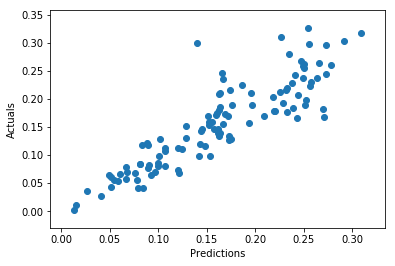

In [20]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predictions')
plt.ylabel('Actuals')

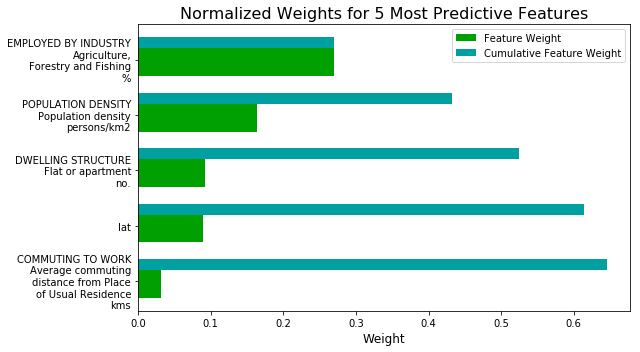

In [21]:
feature_plot_h(best_rf.feature_importances_, X_train, 5)

In [22]:
r2_score(y_pred, y_test)

0.7450028827166401

An R2 of 0.745 is phenomenal! But a lot of importance is definitely coming from the first few features. 

## Feature refinement

With so many features I'm a little concerned about overlap, so to check this let's cut the features used for modelling back to just the top 75 (remembering the original set had ~450).

In [24]:
#Keep only top 75 features
indices = np.argsort(best_rf.feature_importances_)[::-1]
columns = X_train.columns.values[indices[75:]]

drop_cols = list(columns)
X_train_Refined = X_train.copy()
X_train_Refined.drop(drop_cols, axis=1, inplace=True)
X_train_Refined.head()

,,,REGISTERED MOTOR VEHICLES - NUMBER BY TYPE OF VEHICLE Heavy rigid trucks no.,REGISTERED MOTOR VEHICLES - NUMBER BY TYPE OF VEHICLE Articulated trucks no.,"EMPLOYED BY INDUSTRY Agriculture, Forestry and Fishing %",EMPLOYED BY INDUSTRY Manufacturing %,"EMPLOYED BY INDUSTRY Electricity, Gas, Water & Waste Services %",EMPLOYED BY INDUSTRY Wholesale Trade %,EMPLOYED BY INDUSTRY Retail Trade %,EMPLOYED BY INDUSTRY Financial & Insurance Services %,EMPLOYED BY INDUSTRY Education & Training %,"PERSONS WITH POST SCHOOL QUALIFICATIONS Advanced Diploma, or Diploma %",...,"ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE) Working Age Population (15-64 years) %",BIRTHS AND DEATHS Total Fertility Rate (per female) rate,POPULATION DENSITY Population density persons/km2,ABORIGINAL AND TORRES STRAIT ISLANDER PEOPLES Proportion of total population %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Born in North-West Europe %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Born in Southern & Eastern Europe %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Born in South-East Asia %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Total Born Overseas %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,lat
CODE,LABEL,YEAR,,,,,,,,,,,,,,,,,,,,,
112011241,Evans Head,2016,83.0,46.0,6.0,7.9,1.2,1.6,10.0,1.3,10.2,6.9,...,58.7,1.9,9.8,4.5,3.3,0.2,0.5,6.6,2.8,-29.117409
126021591,Ryde,2016,64.0,2.0,0.1,5.0,0.6,4.8,9.3,6.9,7.5,9.8,...,68.8,1.6,3894.9,0.4,3.3,5.0,6.2,45.4,20.1,-33.801575
101021011,Queanbeyan Region,2016,404.0,33.0,2.7,3.2,1.0,1.5,6.2,1.3,7.9,10.9,...,67.5,1.9,5.7,2.0,6.3,1.5,0.8,13.0,2.6,-35.352466
116031315,Hassall Grove - Plumpton,2016,197.0,44.0,0.4,10.9,0.9,3.9,11.2,6.0,5.3,8.9,...,69.9,1.8,3435.0,2.6,1.7,2.2,15.5,42.8,10.1,-33.731667
125021477,Ermington - Rydalmere,2016,97.0,5.0,0.1,6.0,0.8,4.7,9.1,5.4,7.7,9.8,...,67.2,1.9,2233.7,0.9,3.3,2.4,4.7,39.9,14.1,-33.817674


In [27]:
rf = RandomForestRegressor(random_state=42)

parameters = {'n_estimators':[20,40,80,160],
              #'max_depth':[4,8,16,32,64],
              'min_samples_leaf':[1,2,3,4,5]
             }

# TODO: Make a scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(rf, param_grid=parameters, scoring=scorer, verbose = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_Refined, y_train)

# Get the estimator
best_rf = grid_fit.best_estimator_

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.2s
[CV] min_samples_leaf=1, n_estimators=20 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.5s
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.4s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   0.5s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   0.3s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   0.4s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   0.7s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   0.7s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .

[CV] ............. min_samples_leaf=5, n_estimators=160, total=   0.7s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   33.2s finished


In [28]:
# Make predictions using the unoptimized and model
y_pred = best_rf.predict(X_test.drop(drop_cols, axis=1))

In [29]:
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0, 0.5, 'Actuals')

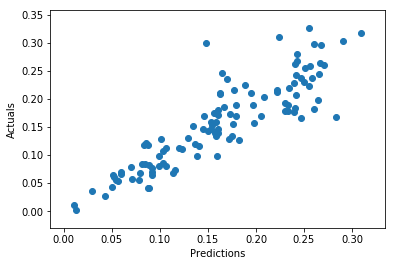

In [30]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predictions')
plt.ylabel('Actuals')

In [31]:
r2_score(y_pred, y_test)

0.7441132579464321

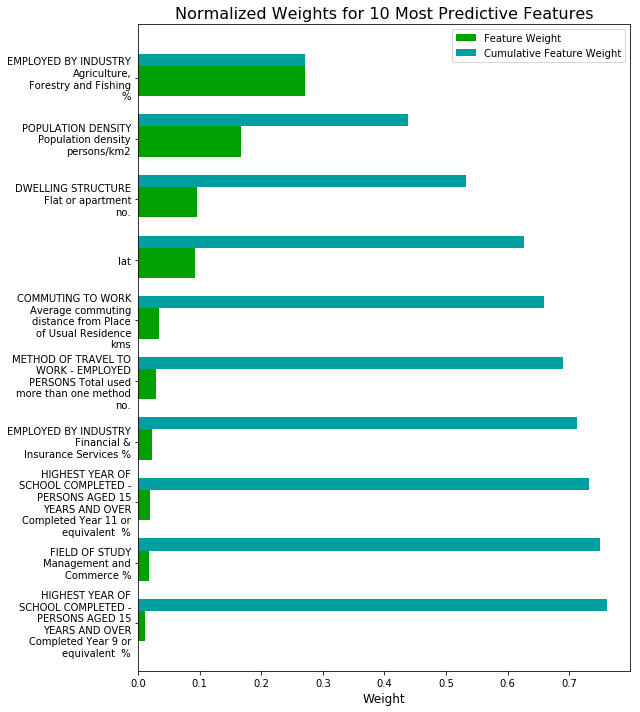

In [33]:
feature_plot_h(best_rf.feature_importances_, X_train.drop(drop_cols, axis=1), 10)

Just... wow! The R2 barely dropped at all, and our key features barely changed.

## Feature impact analysis

But what do these features actually mean? If I increase population density does it decrease or increase solar panel installations (in line with the correlations above)? Or is it multi dimensional where it decreases then increases? By changing the values in the training set then re-predicting, we can model this out quite nicely.
 
I'm choosing to change the base values over a range of +/- the standard deviation of the original feature.

In [31]:
#Create X and y based on preprocessed data
X = pd.read_csv('{}\medians by code.csv'.format(nb_path), na_values='-', thousands=',')
X.rename(columns={'lat':'LATITUDE'}, inplace=True)
X.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)
y = X['Solar Per Household'].copy()
X.drop('Solar Per Household', axis=1, inplace=True)

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
# Initialise RF based on GridSearchCV parameters identified above
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

rf.fit(X_train, y_train)

# Make predictions using the model
y_pred = rf.predict(X_test)
r2_score(y_pred, y_test)

0.7450028827166401

In [35]:
#Keep only top 75 features
indices = np.argsort(rf.feature_importances_)[::-1]
worst_columns = list(X_train.columns.values[indices[75:]])

X_train_Refined = X_train.copy()
X_train_Refined.drop(worst_columns, axis=1, inplace=True)

In [36]:
# Initialise another RF based on GridSearchCV parameters identified above for the leaner dataset
lean_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

lean_rf.fit(X_train_Refined, y_train)

# Make predictions using the model
y_pred = lean_rf.predict(X_test.drop(worst_columns, axis=1))
r2_score(y_pred, y_test)

0.7441132579464321

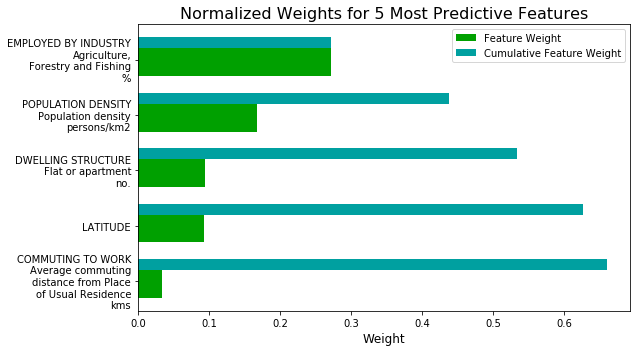

In [38]:
feature_plot_h(lean_rf.feature_importances_, X_train_Refined, 5)

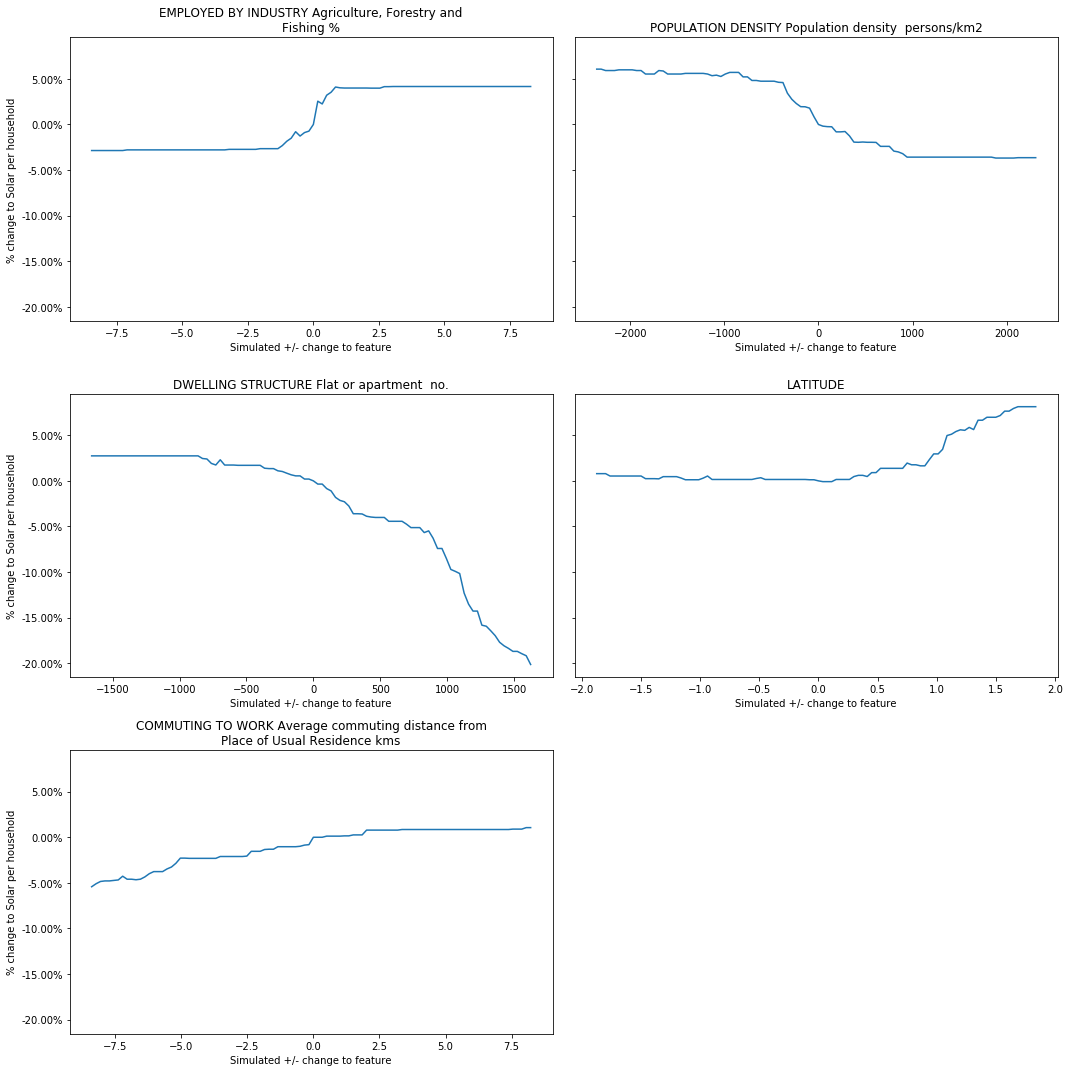

In [37]:
feature_impact_plot(lean_rf, X_train_Refined, 5, 'Solar per household')

## Regression Model

I ran this just to see how it turned out, but it turned out garbage, obviously because of the high level of feature-interdependence.

In [75]:
#Split into train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train_scaled, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test_scaled)
y_train_preds = lm_model.predict(X_train_scaled)

-12.823733224902043

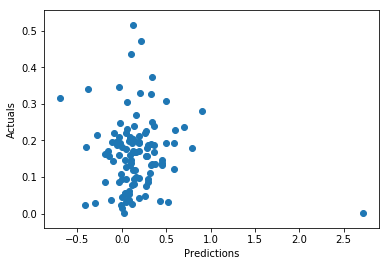

In [79]:
plt.scatter(y_test_preds, y_test)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
r2_score(y_test, y_test_preds)

In [24]:
def coef_weights_lm(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used (not scaled)
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [76]:
#Return coefficients from linear regression model
coef_df = coef_weights_lm(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
163,JOBS IN AUSTRALIA Number of Employee Jobs - To...,37.516099,37.516099
50,REGISTERED MOTOR VEHICLES - NUMBER BY TYPE OF ...,26.787087,26.787087
41,BUILDING APPROVALS Value of private sector dwe...,-26.786498,26.786498
42,BUILDING APPROVALS Value of total private sect...,26.388701,26.388701
177,METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS To...,-22.614976,22.614976
37,BUILDING APPROVALS Private sector dwellings ex...,22.431191,22.431191
38,BUILDING APPROVALS Total private sector dwelli...,-21.089800,21.089800
142,JOBS IN AUSTRALIA Number of Jobs - Males no.,-17.261870,17.261870
40,BUILDING APPROVALS Value of private sector hou...,-16.985321,16.985321
36,BUILDING APPROVALS Private sector houses no.,16.278377,16.278377


## Boosted Learning
Given the large number of strong correlations and relatively unskewed historgram plots, the main weakness of AdaBoost being sensitivity to outliers and noisy data is minimal.

In [80]:
# Initialize the regressor
clf = AdaBoostRegressor(random_state=42)

In [84]:
X_train

,,,NUMBER OF BUSINESSES Number of non-employing businesses no.,NUMBER OF BUSINESSES 1-4 employees no.,NUMBER OF BUSINESSES 5-19 employees no.,NUMBER OF BUSINESSES 20 or more employees no.,NUMBER OF BUSINESSES Total number of businesses no.,BUSINESS ENTRIES Number of non-employing business entries no.,BUSINESS ENTRIES 1-4 employees no.,BUSINESS ENTRIES 5-19 employees no.,BUSINESS ENTRIES 20 or more employees no.,BUSINESS ENTRIES Total number of business entries no.,...,RELIGIOUS AFFILIATION Islam %,RELIGIOUS AFFILIATION Judaism %,RELIGIOUS AFFILIATION Other Religions %,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %",RELIGIOUS AFFILIATION Inadequately described or not stated %,AUSTRALIAN CITIZENSHIP Australian citizen %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,AUSTRALIAN CITIZENSHIP Australian Citizenship - Not stated %,SPEAKS A LANGUAGE OTHER THAN ENGLISH AT HOME Proportion of total population %,lat
CODE,LABEL,YEAR,,,,,,,,,,,,,,,,,,,,,
121011401,St Leonards - Naremburn,2016,1588.0,842.0,399.0,173.000000,2999.0,247.0,110.00000,8.000000,3.000000,367.0,...,1.400000,0.700000,0.700000,39.0,10.7,71.3,21.0,7.7,33.9,-33.816857
118021348,Coogee - Clovelly,2016,1585.0,713.0,144.0,26.000000,2471.0,288.0,115.00000,10.000000,3.000000,414.0,...,0.600000,3.300000,0.300000,35.3,12.3,75.9,14.7,9.4,17.2,-33.916685
120031393,Croydon Park - Enfield,2016,905.0,475.0,91.0,8.000000,1476.0,174.0,85.00000,4.000000,3.000000,263.0,...,2.100000,0.100000,0.500000,21.6,7.3,82.4,12.6,5.0,48.0,-34.880250
109031180,Corowa,2016,320.0,141.0,69.0,9.000000,541.0,43.0,15.00000,5.000000,3.855263,58.0,...,0.300000,0.748598,0.500000,24.1,9.1,90.7,2.4,6.9,2.5,-35.999575
121031409,Pymble,2016,1321.0,665.0,147.0,36.000000,2168.0,215.0,72.00000,6.000000,3.855263,288.0,...,0.900000,1.400000,1.000000,30.9,6.8,84.7,11.6,3.7,26.7,-33.745019
103021064,Cowra Region,2016,464.0,217.0,67.0,8.000000,755.0,55.0,12.00000,3.000000,3.855263,74.0,...,0.100000,0.748598,0.400000,18.4,9.1,90.7,1.9,7.5,2.4,-33.811129
121031412,Wahroonga (East) - Warrawee,2016,1294.0,645.0,109.0,24.000000,2077.0,185.0,83.00000,3.000000,3.855263,268.0,...,0.700000,0.500000,0.900000,28.4,8.2,84.9,9.9,5.2,21.5,-33.724191
105031106,Wellington,2016,545.0,291.0,74.0,15.000000,927.0,55.0,27.00000,3.000000,3.855263,85.0,...,0.100000,0.748598,0.400000,16.8,20.0,80.3,1.8,17.9,1.6,-32.554282
124031460,Glenmore Park - Regentville,2016,593.0,425.0,69.0,12.000000,1103.0,130.0,78.00000,3.000000,3.855263,207.0,...,1.400000,0.748598,1.500000,20.6,5.5,90.4,5.3,4.3,14.1,-33.778013


In [81]:
# Not sure if it is worth searching other sub-"model"s like SVC instead of decision tree through the base_estimator? 
parameters = {'n_estimators':[10,20,40,80,120],
             'learning_rate':[0.0001,0.001,0.01],
             }

# TODO: Make a scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, verbose=2)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)


C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


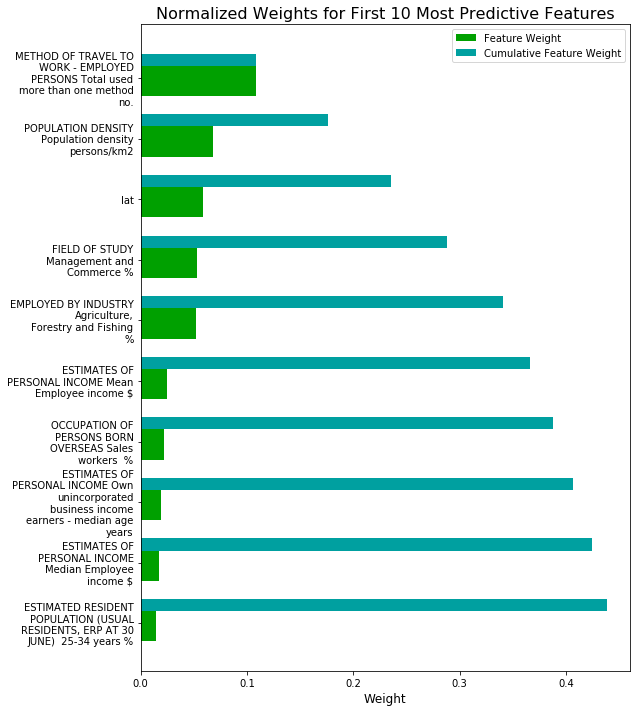

In [85]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
feature_plot_h(importances, X_train, 10)

In [87]:
r2_score(best_predictions, y_test)

0.32798678976067486

In [83]:
best_clf

AdaBoostRegressor(base_estimator=None, learning_rate=2, loss='linear',
         n_estimators=160, random_state=42)

In [ ]:
# Do something else from supervised learning 

# Probably should PCA

# Do an analysis based on multiple years, dropping columns with significant NaNs
# Do a trend series by histogram bins based on key features for installations over time
# Create some theoretical series based on changing the key features and plot these, to show the relationship
    # e.g. what if population density was = min of series vs = max

# Maybe try SVM while I'm at it, since the number of rows isn't huge, but the number of dimensions is